In [1]:
import sys
sys.path.append('..')
%env WORKDIR ~/Documents/weatherpy-work

env: WORKDIR=~/Documents/weatherpy-work


In [2]:
import pandas as pd
from shapely.geometry import Polygon

def load_chase_alley():
    bdys_df = pd.read_csv('chasealley.csv')
    # depending on the version of shapely, we might have to manually close the polygon
    bdys_df = bdys_df.append(bdys_df.loc[0])
    latlon_mat = bdys_df[['lat', 'lon']].as_matrix()
    return bdys_df, Polygon(latlon_mat)

In [3]:
from wxdata import stormevents

df = stormevents.tornadoes('1996-01-01 00:00', '2017-12-31 23:59', tz='CST',
                          hours=range(12, 24), 
                          months=['April', 'May', 'June'])

/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))
/Users/jitang/anaconda/envs/gpdenv/lib/python3.6/multiprocessing/pool.py:44: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  return list(map(*args))


In [5]:
df.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'magnitude', 'magnitude_type', 'flood_cause', 'category', 'tor_f_scale',
       'tor_length', 'tor_width', 'tor_other_wfo', 'tor_other_cz_state',
       'tor_other_cz_fips', 'tor_other_cz_name', 'begin_range',
       'begin_azimuth', 'begin_location', 'end_range', 'end_azimuth',
       'end_location', 'begin_lat', 'begin_lon', 'end_lat', 'end_lon',
       'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

In [6]:
bdys_df, chase_alley = load_chase_alley()
chaseable_tors = stormevents.filter_region(df, chase_alley)

In [7]:
chaseable_tors.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_range,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source
1,199605,22,1915,199605,22,1920,2033924,5556025,COLORADO,8.0,...,19.0,N,LAIRD,40.37,-102.10,40.37,-102.10,TORNADO TOOK DOWN SEVERAL POWER POLES AND DAMA...,NaN,PDC
3,199605,31,2013,199605,31,2014,2053076,5579344,TEXAS,48.0,...,6.0,E,CLARENDON,34.93,-100.82,34.93,-100.80,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
4,199605,22,1930,199605,22,1930,2035430,5554505,NEBRASKA,31.0,...,2.0,NE,MILFORD,40.78,-97.02,40.78,-97.02,A shed was destroyed 11/4 miles east of Superi...,NaN,PDC
5,199605,31,1817,199605,31,1818,2053066,5579333,TEXAS,48.0,...,5.0,E,CLAUDE,35.12,-101.30,35.12,-101.28,ARES Storm Spotters reported a brief tornado t...,NaN,PDC
6,199606,23,1430,199606,23,1430,2039266,5562050,NEBRASKA,31.0,...,10.0,S,LOUISVILLE,40.85,-96.15,40.85,-96.15,A tornado briefly touched down on Hwy 50 in Ca...,NaN,PDC


In [8]:
len(chaseable_tors)

7227

In [9]:
from wxdata.stormevents import tors
tors_fixed = tors.correct_tornado_times(chaseable_tors)

In [70]:
from wxdata.utils import datetime_buckets
from wxdata.extras import st_clusters
from wxdata.stormevents import time_partition, filter_on_year

def buckets_for_year(year):
    t1 = pd.Timestamp(year=year, month=4, day=1, hour=0, minute=0)
    t2 = pd.Timestamp(year=year, month=7, day=1, hour=0, minute=0)
    return datetime_buckets(t1, t2, '1 day', tz='CST')

def clusters_for_year(df, year, min_samples=15):
    ret = {}
    for (start, _), datetors in time_partition(df, buckets_for_year(year)):
        dateclusts = st_clusters(datetors, eps_km=60, eps_min=60, min_samples=min_samples)
        if dateclusts:
            ret[start] = dateclusts
    return ret

In [71]:
def dates_with_clusters(found_clusts):
    ret = pd.DataFrame()
    ret['clust_dates'] = clusts.keys()
    ret['year'] = ret['clust_dates'].dt.year
    ret['month'] = ret['clust_dates'].dt.month
    ret['day'] = ret['clust_dates'].dt.day
    ret['size'] = ret.apply(lambda r: clusts[r.clust_dates].numpoints(), axis=1)
    ret['biggest'] = ret.apply(lambda r: len(clusts[r.clust_dates].biggest_cluster()), axis=1)
    return ret

In [72]:
aggregated = []
for year in range(1996, 2018):
    clusts = clusters_for_year(tors_fixed, year)
    aggregated.append(dates_with_clusters(clusts))
    
all_clust_dates = pd.concat(aggregated)

In [73]:
all_clust_dates.head()

,clust_dates,year,month,day,size,biggest
0,1996-04-21 00:00:00-06:00,1996,4,21,88,62
1,1996-05-08 00:00:00-06:00,1996,5,8,94,94
2,1996-05-09 00:00:00-06:00,1996,5,9,17,17
3,1996-05-17 00:00:00-06:00,1996,5,17,56,56
4,1996-05-22 00:00:00-06:00,1996,5,22,23,23


In [130]:
clust_distr = all_clust_dates.groupby(['month', 'day']).count().reset_index()[['month', 'day', 'clust_dates']]
clust_distr['date'] = clust_distr.apply(lambda r: pd.Timestamp(year=2017, month=r.month, day=r.day), axis=1)

fills = pd.DataFrame(columns=['month', 'day', 'clust_dates', 'date'])
from datetime import date
for fill_start, fill_end in buckets_for_year(2017):
    to_date = pd.Timestamp(year=fill_start.year, month=fill_start.month, 
                           day=fill_start.day).to_datetime64()
    
    if to_date not in clust_distr.date.values:
        row = {
            'month': fill_start.month,
            'day': fill_start.day,
            'clust_dates': 0,
            'date': to_date
        }
        fills.loc[len(fills)] = row
        
clust_distr = pd.concat([clust_distr, fills])

In [133]:
clust_distr.sort_values('clust_dates', ascending=False).head(10)

,month,day,clust_dates,date
70,6,12,11,2017-06-12
37,5,10,9,2017-05-10
69,6,11,9,2017-06-11
74,6,16,8,2017-06-16
57,5,30,8,2017-05-30
63,6,5,8,2017-06-05
61,6,3,8,2017-06-03
51,5,24,8,2017-05-24
80,6,22,8,2017-06-22
52,5,25,7,2017-05-25


In [76]:
clust_biggest = all_clust_dates.loc[:, ['clust_dates', 'biggest']]

def to_dummy_date(row):
    date_ = row.clust_dates
    return pd.Timestamp(year=2017, month=date_.month, day=date_.day)

clust_biggest['dummy_date'] = clust_biggest.apply(to_dummy_date, axis=1)

In [196]:
clust_biggest.sort_values('biggest', ascending=False).head(20)

,clust_dates,biggest,dummy_date
6,1999-05-03 00:00:00-06:00,629,2017-05-03
9,2008-05-23 00:00:00-06:00,449,2017-05-23
11,2016-05-24 00:00:00-06:00,296,2017-05-24
7,2007-05-04 00:00:00-06:00,270,2017-05-04
6,2011-05-24 00:00:00-06:00,265,2017-05-24
3,2012-04-14 00:00:00-06:00,258,2017-04-14
4,2003-05-04 00:00:00-06:00,256,2017-05-04
2,1999-04-08 00:00:00-06:00,251,2017-04-08
3,2014-05-11 00:00:00-06:00,220,2017-05-11
1,2010-05-10 00:00:00-06:00,219,2017-05-10


In [184]:
def moving_avg(numdays):
    barebones = clust_distr[['date', 'clust_dates']].sort_values('date')
    barebones.set_index('date', inplace=True)
    window = str(numdays) + 'd'
    movingavg = barebones.rolling(window=window, min_periods=numdays).mean()
    return movingavg[~movingavg.clust_dates.isna()]

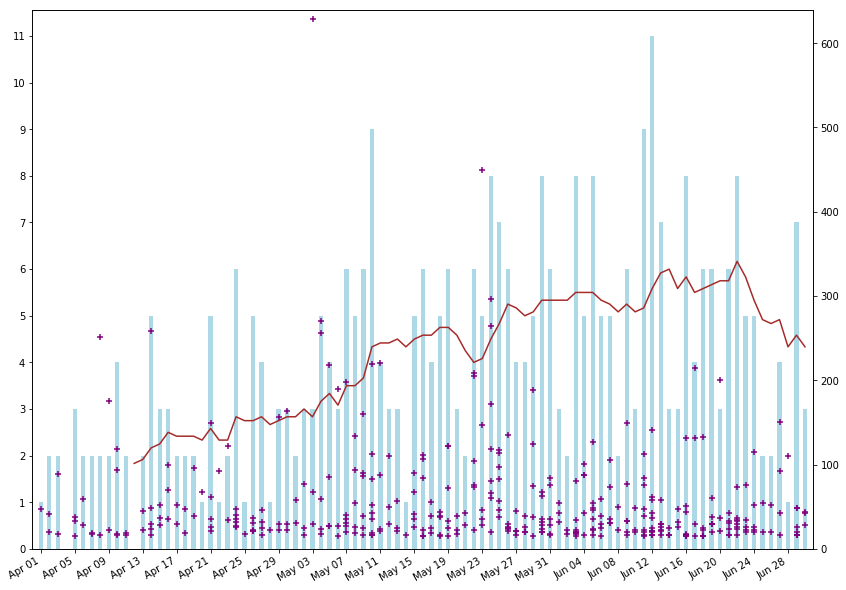

In [193]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date

fig, ax = plt.subplots(figsize=(14, 11))
ax.bar(clust_distr['date'], clust_distr['clust_dates'], color='lightblue', width=0.5)
ax.plot(moving_avg(12), color='brown', linewidth=1.5)

datemin = date(2017, 3, 31)
datemax = date(2017, 7, 1)
ax.set_xlim(datemin, datemax)
ax.set_yticks(range(max(clust_distr.clust_dates) + 1))

ax2 = ax.twinx()
ax2.scatter(clust_biggest['dummy_date'].values, clust_biggest['biggest'].values, 
            color='purple', marker='+', s=45)
ax2.set_ylim(0, clust_biggest['biggest'].max() + 10)

ax2.set_xlim(datemin, datemax)
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=4))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

fig.autofmt_xdate()